In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import dill as pickle
import aesara
import pandas as pd
import pycmtensor as cmt
from pycmtensor.models import MNLogit
from pycmtensor.optimizers import Adam
from pycmtensor.expressions import Beta, Weights
from pycmtensor.results import Results, Predict

In [6]:
from aesara.tensor.var import TensorVariable
from aesara.tensor.sharedvar import TensorSharedVariable
import numpy as np
x = cmt.aet.vector("x")
one = aesara.shared(np.ones(1, dtype=aesara.config.floatX))
b_cost = Beta("b_cost", 1.0, None, None, 0)
print(type(one))
print(isinstance(one, TensorSharedVariable))
print(one == 1)
type(x)

<class 'aesara.tensor.sharedvar.TensorSharedVariable'>
True
False


aesara.tensor.var.TensorVariable

In [8]:
import numpy as np
import aesara.tensor as aet
b_cost = Beta("b_cost", 1.0, None, None, 0)
x = cmt.aet.vector("x")
one = aesara.shared(np.ones(1, dtype=aesara.config.floatX))
u = b_cost * (aet.eq(x, 1))
fn = aesara.function([x], u)
fn(np.ones(3,))

array([1., 1., 1.])

In [3]:

swissmetro = pd.read_csv("data/swissmetro.dat", sep="\t")
db = cmt.Database(name="swissmetro", pandasDatabase=swissmetro, choiceVar="CHOICE")
globals().update(db.variables)
# Removing some observations
exclude = ((PURPOSE != 1) * (PURPOSE != 3) + (CHOICE == 0)) > 0
db.remove(exclude)

# additional steps to format database
db.data["CHOICE"] -= 1 # set the first choice to 0
db.choices = sorted(db.data["CHOICE"].unique()) # save original choices
db.autoscale(variables=['TRAIN_CO', 'TRAIN_TT', 'CAR_CO', 'CAR_TT', 
    'SM_CO', 'SM_TT'], default=100., verbose=False)

# declare model params here
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_dist = Beta("b_dist", 0.0, None, None, 0)
b_school = Beta("b_school", 0.0, None, None, 0)
asc_train = Beta("asc_train", 0.0, None, None, 0)
asc_car = Beta("asc_car", 0.0, None, None, 0)
asc_sm = Beta("asc_sm", 0.0, None, None, 1)

U_1 = b_cost * db["TRAIN_CO"] + b_time * db["TRAIN_TT"] + asc_train
U_2 = b_cost * db["SM_CO"] + b_time * db["SM_TT"] + asc_sm
U_3 = b_cost * db["CAR_CO"] + b_time * db["CAR_TT"] + asc_car

# specify the utility function and the availability conditions
U = [U_1, U_2, U_3]
AV = [db["TRAIN_AV"], db["SM_AV"], db["CAR_AV"]]

mymodel = MNLogit(u=U, av=AV, database=db, name="mymodel")
mymodel.add_params(locals())

# train function
model = cmt.train(mymodel, database=db, optimizer=Adam, batch_size=128, lr_init=0.01, max_epoch=399, notebook=True)

with open("myModel.pkl", "rb") as f:
    model = pickle.load(f)

result = Results(model, db, show_weights=True)

Building model...
dataset: swissmetro (6768)
batch size: 128
batches per epoch: 52
validation frequency: 52

Training model...


Loglikelihood:  -6964.662979  Score: 0.134

Epoch    0/20748:   0%|          | 0.00/20.7k [00:00<?, ?it/s]

Optimization complete with accuracy of 62.544% with maximum loglikelihood reached @ epoch 366.

Results for model: mymodel
Build time: 00:00:06
Estimation time: 00:00:25
Estimation rate: 15.939 epochs/s
Seed value: 999
Number of Beta parameters: 4
Sample size: 6768
Excluded data: 3960
Init loglikelihood: -6964.663
Final loglikelihood: -5590.573
Final loglikelihood reached at: epoch 366
Likelihood ratio test: 2748.180
Accuracy: 62.544%
Rho square: 0.197
Rho bar square: 0.197
Akaike Information Criterion: 11189.15
Bayesian Information Criterion: 11216.43
Final gradient norm: 0.281

Statistical Analysis:
              Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_car     0.13053  0.042008   3.107292  0.001888     0.058141    2.245076     0.024763
asc_train -0.608235  0.054479  -11.16467       0.0     0.004376 -138.994986          0.0
b_cost    -0.003485  0.002484   -1.40319   0.16056     0.009324   -0.373755     0.708587
b_time    -1.156614  0.053801 -21.4

In [4]:
from aesara.tensor.random.utils import RandomStream

class ResLogitLayer:
    def __init__(self, input, w_in, w_out, activation_in=None, activation_out=None):
        assert w_in.shape[1].eval() == w_out.shape[0].eval()
        if isinstance(input, (list, tuple)):
            assert len(input) == w_in.shape[0].eval(), f"index.0 of w_in must be of the same length as input"
            input = aet.stacklists(input).flatten(2)

        assert isinstance(w_in, (Weights)), "w_in must be of type Weights"
        assert isinstance(w_out, (Weights)), "w_out must be of type Weights"
        self.w_in = w_in()
        self.w_out = w_out()
        if activation_in == None:
            activation_in = aet.sigmoid
        if activation_out == None:
            activation_out = aet.sigmoid
            
        h = activation_in(aet.dot(input.T, self.w_in))
        output = activation_out(aet.dot(h, self.w_out)).T
        self.input = input
        self.weights = [self.w_in, self.w_out]
        self.output = output + input

    
    def __repr__(self):
        return f"ResLogitLayer([{self.w_in.shape.eval()}, {self.w_out.shape.eval()}])"

The output file is available at viz/print.png


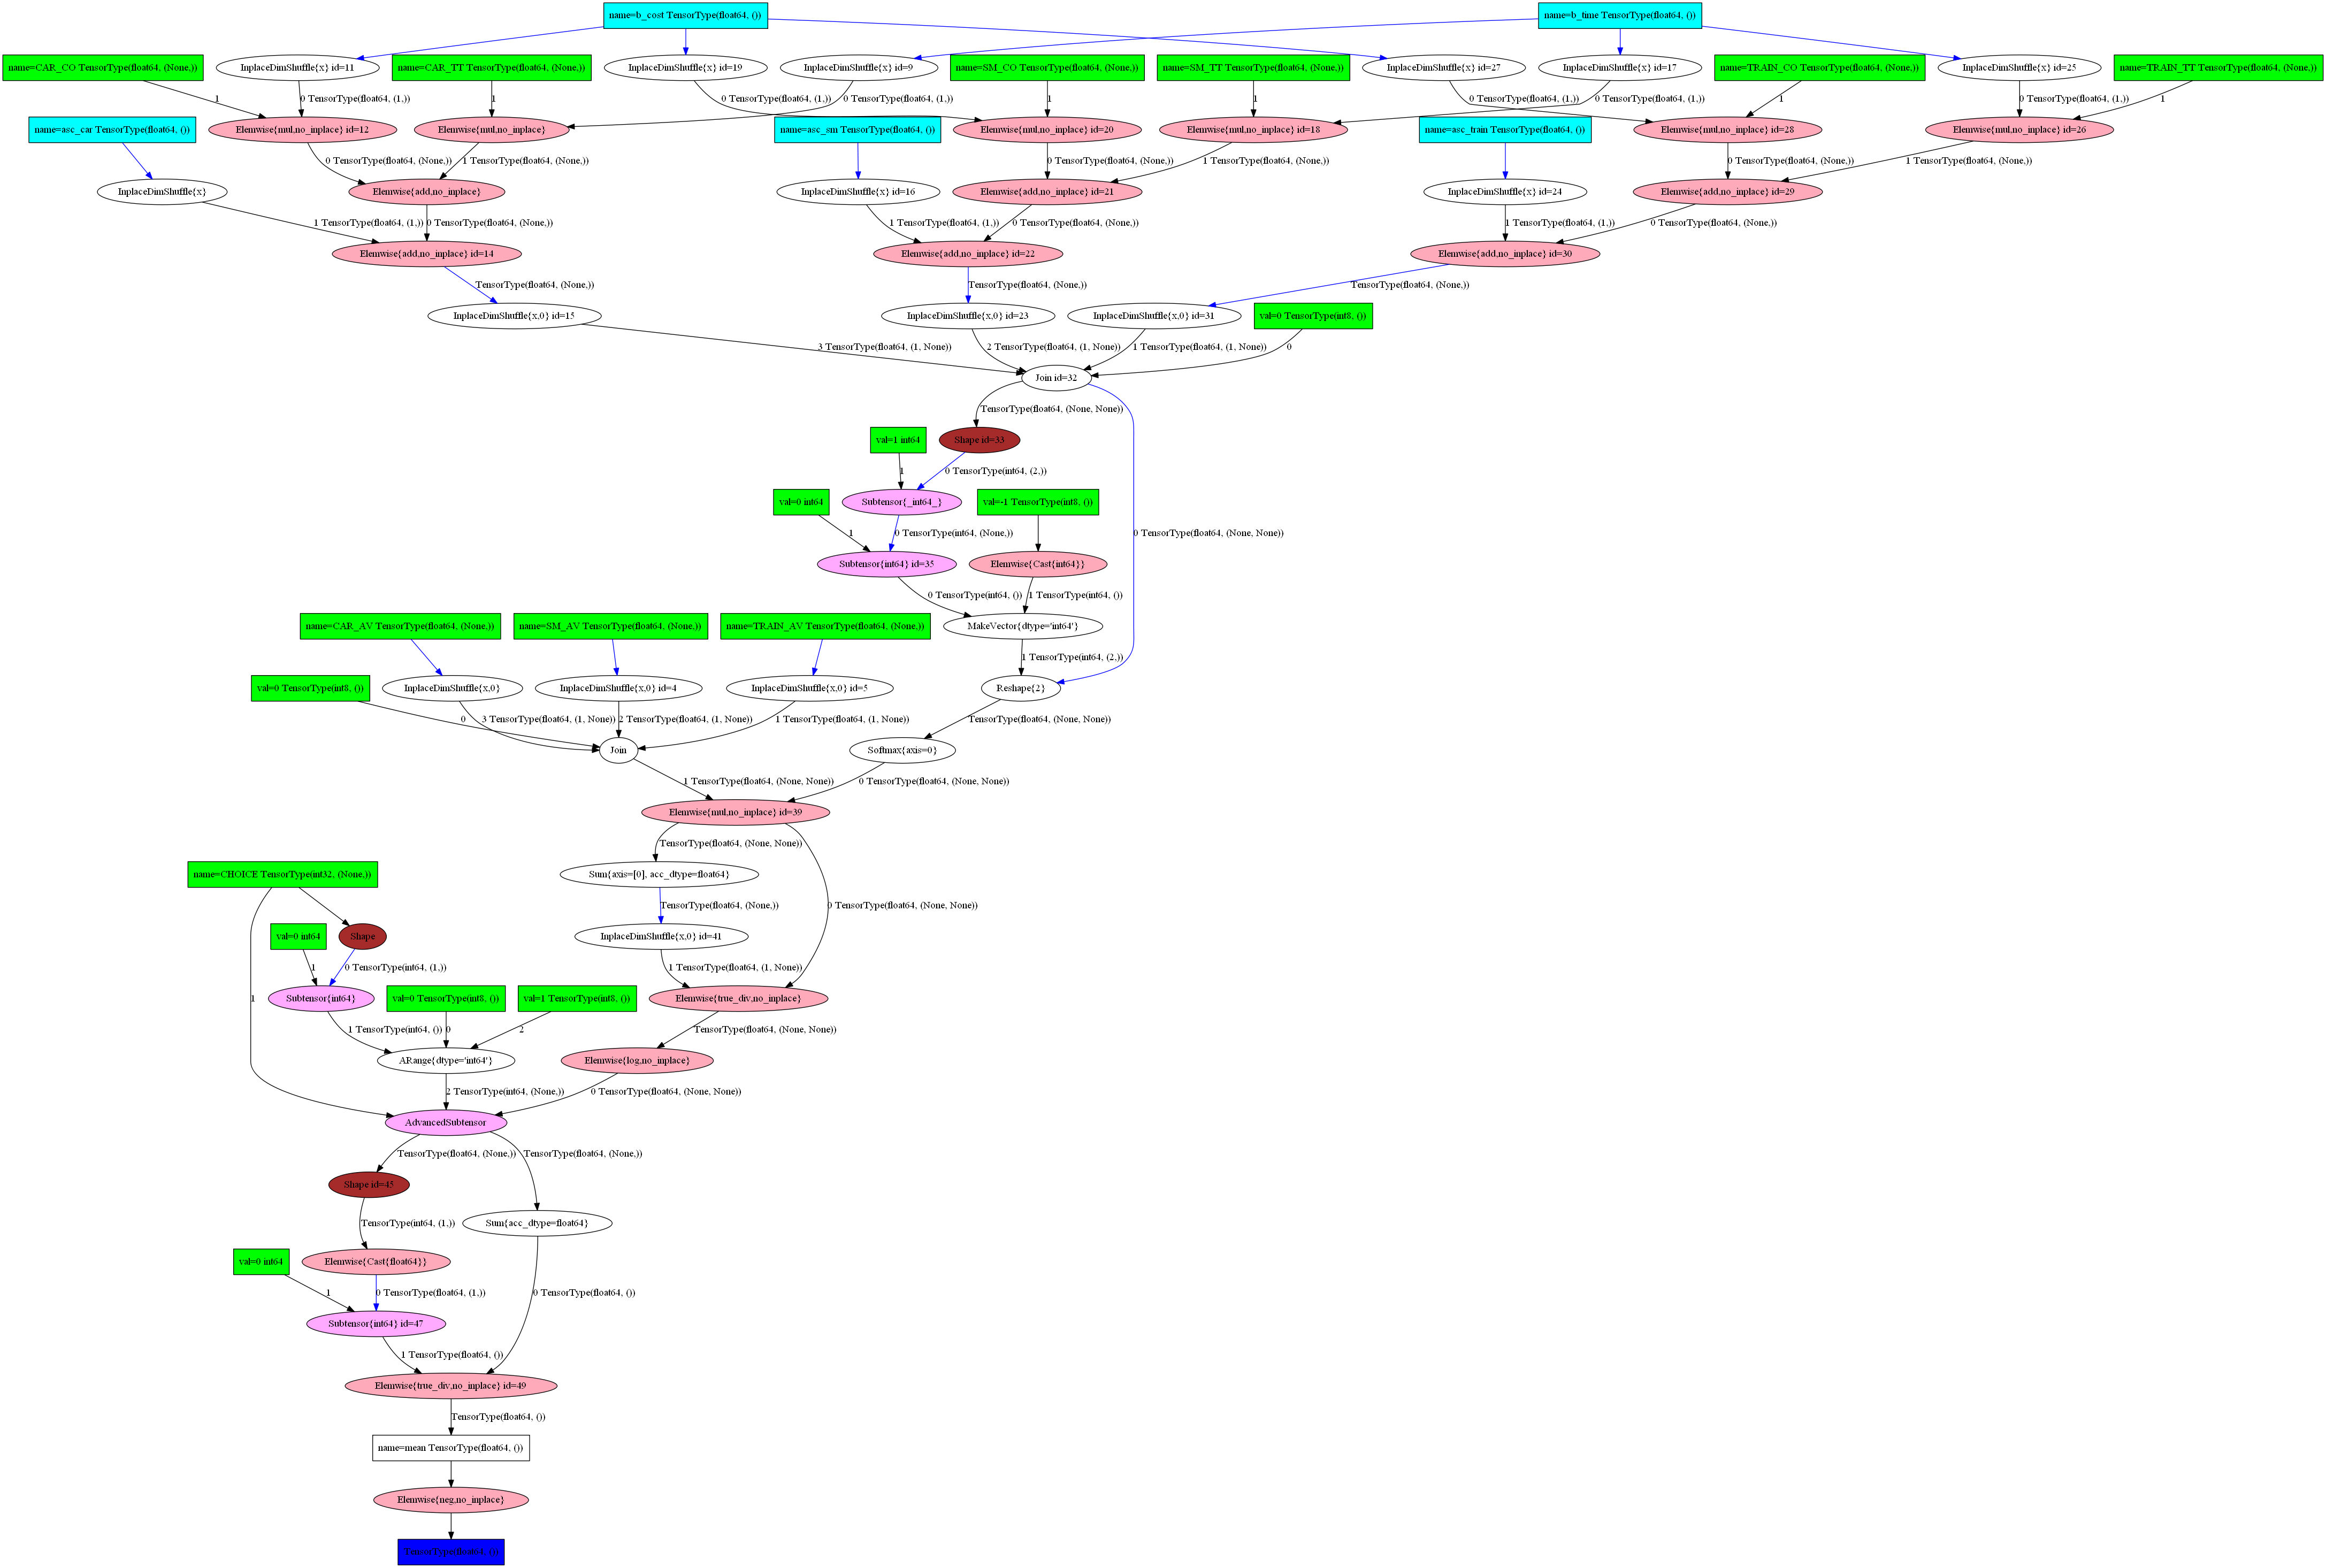

In [5]:
import aesara.d3viz as d3v
d3v.d3viz(model.loglikelihood, 'viz/MNLogit.html')

aesara.printing.pydotprint(mymodel.cost, "viz/print.png")
from IPython.display import Image
Image("viz/print.png", width="80%")

In [6]:
from pycmtensor.results import Predict
from pycmtensor.pycmtensor import PyCMTensorModel
import dill as pickle

class MNLmodel(PyCMTensorModel):
    def __init__(self, db):
        super().__init__(db)

with open("myModel.pkl", "rb") as f:
    model = pickle.load(f)

Predict(model, db).choices()

,CHOICE
0,1
1,1
2,1
3,2
4,1
...,...
6763,1
6764,1
6765,1
6766,1


In [7]:
from tqdm import tqdm, trange
from time import sleep

pbar = tqdm(total=100)
for i in range(10):
    sleep(0.1)
    pbar.update(10)
pbar.close()

pbar.format_dict

100%|██████████| 100/100 [00:01<00:00, 90.50it/s]


{'n': 100,
 'total': 100,
 'elapsed': 1.1059203147888184,
 'ncols': None,
 'nrows': None,
 'prefix': '',
 'ascii': False,
 'unit': 'it',
 'unit_scale': False,
 'rate': None,
 'bar_format': None,
 'postfix': None,
 'unit_divisor': 1000,
 'initial': 0,
 'colour': None}